In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse, scipy.optimize, scipy.linalg
from numba import jit
import timeit
import time
from tqdm import tqdm
from google.colab import drive
import imageio.v3 as iio

In [75]:
drive.mount('/content/drive')

Mounted at /content/drive


1D Schrodinger equation:
$$ i \frac{\partial}{\partial t'} \psi = -\frac{1}{2}\frac{\partial^2}{\partial x'^2}\psi + V(x') \psi $$
Finite differnce method:
$$i\frac{\psi_{j}^{m+1} - \psi_{j}^{m}}{\Delta t} = - \frac{1}{2}\frac{\psi_{j+1}^{m} -2\psi_j^m + \psi_{j-1}^{m}}{\Delta x^2} +V(x_j)\psi_j^m$$

So we get recurrence:
$$\psi_{j}^{m+1} = \psi_j^m + \frac{i}{2}\frac{\Delta t}{\Delta x^2}\left(\psi_{j+1}^{m} -2\psi_j^m + \psi_{j-1}^{m}\right) - i \Delta tV(x_j)\psi_j^m$$

In [3]:
@jit(nopython=True, nogil=True)
def psi_evolution(psi_0, V, L, N_x, t_end, N_t):
  x = np.linspace(-L, L, N_x)
  t = np.linspace(0, t_end, N_t)
  dt = t[1] - t[0]
  dx = x[1] - x[0]
  psi = np.zeros((N_x, N_t), dtype=np.complex128)
  psi[:, 0] = psi_0
  sd = np.zeros((N_x, ), dtype=np.complex128)
  for m in range(N_t-1):
    sd = -2 * psi[:, m]
    sd[:-1] += psi[1:, m]
    sd[1:] += psi[:-1, m]
    sd[0] = sd[1]
    sd[-1] = sd[-2]
    psi[:, m+1] = psi[:, m] + (1j / 2) * (dt / dx ** 2) * sd - 1j * dt * V * psi[:, m]

    normal = np.sum(np.absolute(psi[:, m+1]) ** 2) * dx
    psi[:, m+1] = psi[:, m+1] / np.sqrt(normal)

  return psi

In [5]:
def psi_evolution_nojit(psi_0, V, L, N_x, t_end, N_t):
  x = np.linspace(-L, L, N_x)
  t = np.linspace(0, t_end, N_t)
  dt = t[1] - t[0]
  dx = x[1] - x[0]
  psi = np.zeros((N_x, N_t), dtype=np.complex128)
  psi[:, 0] = psi_0
  sd = np.zeros((N_x, ), dtype=np.complex128)
  for m in range(N_t-1):
    sd = -2 * psi[:, m]
    sd[:-1] += psi[1:, m]
    sd[1:] += psi[:-1, m]
    sd[0] = sd[1]
    sd[-1] = sd[-2]
    psi[:, m+1] = psi[:, m] + (1j / 2) * (dt / dx ** 2) * sd - 1j * dt * V * psi[:, m]

    normal = np.sum(np.absolute(psi[:, m+1]) ** 2) * dx
    psi[:, m+1] = psi[:, m+1] / np.sqrt(normal)

  return psi

In [7]:
L = 5
t_end = 0.1
N_x = 100
N_t = 10 ** 5
x = np.linspace(-L, L, N_x)
t = np.linspace(0, t_end, N_t)
dt = t[1] - t[0]
dx = x[1] - x[0]

p_0 = 10
x_0 = 0
sigma_x = 1
psi_0 = np.exp(-(x-x_0)**2 / (2 * sigma_x ** 2)) * np.exp(+1j*p_0*x)
norm = np.sqrt(np.sum(np.absolute(psi_0) ** 2) * dx)
psi_0 = psi_0 / norm

V = x ** 2 / 2

print(dt / dx ** 2)

9.801098010980072e-05


In [46]:
psi_m = psi_evolution(psi_0, V, L, N_x, t_end, N_t)

In [ ]:
plt.plot(x, np.abs(psi_m[:,1201]))
plt.plot(x, psi_m[:,1201].imag)
plt.plot(x, psi_m[:,1201].real)

In [10]:
L = 5
t_end = 0.1
N_x = [100 * i for i in range(1, 11)]
N_t = 10 ** 5
p_0 = 10
x_0 = 0
sigma_x = 1
time_jit = []
for i in range(10):
    x = np.linspace(-L, L, N_x[i])
    V = x ** 2 / 2
    psi_0 = np.exp(-(x-x_0)**2 / (2 * sigma_x ** 2)) * np.exp(+1j*p_0*x)
    norm = np.sqrt(np.sum(np.absolute(psi_0) ** 2) * dx)
    psi_0 = psi_0 / norm
    time_start = time.time()
    psi_m = psi_evolution(psi_0, V, L, N_x[i], t_end, N_t)
    time_end = time.time()
    time_jit.append(time_end - time_start)

In [11]:
time_jit

[0.5677733421325684,
 1.6339216232299805,
 1.597463846206665,
 2.2187886238098145,
 2.882314920425415,
 4.5719077587127686,
 4.025223731994629,
 4.5939249992370605,
 6.879545211791992,
 6.950857162475586]

In [13]:
L = 5
t_end = 0.1
N_x = [100 * i for i in range(1, 11)]
N_t = 10 ** 5
p_0 = 10
x_0 = 0
sigma_x = 1
time_nojit = []
for i in range(10):
    x = np.linspace(-L, L, N_x[i])
    V = x ** 2 / 2
    psi_0 = np.exp(-(x-x_0)**2 / (2 * sigma_x ** 2)) * np.exp(+1j*p_0*x)
    norm = np.sqrt(np.sum(np.absolute(psi_0) ** 2) * dx)
    psi_0 = psi_0 / norm
    time_start = time.time()
    psi_m = psi_evolution_nojit(psi_0, V, L, N_x[i], t_end, N_t)
    time_end = time.time()
    time_nojit.append(time_end - time_start)

In [14]:
time_nojit

[4.707475662231445,
 4.255186080932617,
 4.701694488525391,
 6.7646403312683105,
 6.064746618270874,
 8.381064653396606,
 8.838996410369873,
 10.272355318069458,
 12.583539485931396,
 13.678959846496582]

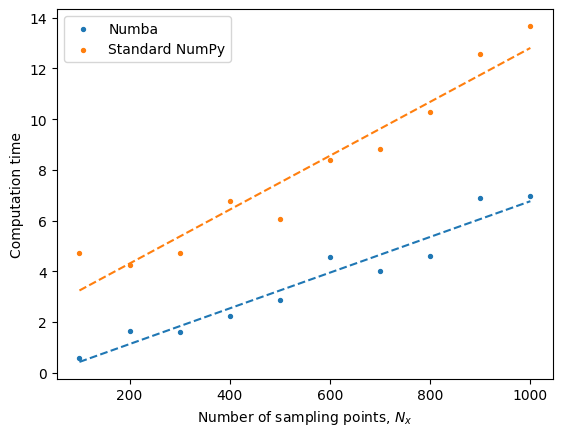

In [41]:
linear_f = lambda x, a, b: a * x + b
pjit, pcovjit = scipy.optimize.curve_fit(linear_f, N_x, time_jit)
pnojit, pcovnojit = scipy.optimize.curve_fit(linear_f, N_x, time_nojit)
plt.scatter(N_x, time_jit, s=8, label='Numba')
plt.plot(N_x, linear_f(np.array(N_x), *pjit), '--')
plt.scatter(N_x, time_nojit, s=8, label='Standard NumPy')
plt.plot(N_x, linear_f(np.array(N_x), *pnojit), '--')
plt.xlabel(r'Number of sampling points, $N_x$')
plt.ylabel('Computation time')
plt.legend()

Trying more stable method:

In [5]:
L = 30
N_x = 1000
N_t = 100
x = np.linspace(-L, L, N_x)
t = np.linspace(0, 20, N_t)
dt = t[1] - t[0]
dx = x[1] - x[0]

p_0 = 10
x_0 = 0
sigma_x = 1
psi_0 = np.exp(-(x-x_0)**2 / (2 * sigma_x ** 2)) * np.exp(+1j*p_0*x)
norm = np.sqrt(np.sum(np.absolute(psi_0) ** 2) * dx)
psi_0 = psi_0 / norm

psi = np.zeros((N_x, N_t), dtype=np.complex64)
psi[:, 0] = psi_0


V = x ** 2 / 2

In [ ]:
gamma = (1j / 4) * (dt / dx ** 2)
RHS_matrix = np.diag(1-2*gamma-1j*dt*V/2) + np.diag([gamma]*(N_x-1), 1) + np.diag([gamma]*(N_x-1), -1)
LHS_matrix = np.diag(1+2*gamma+1j*dt*V/2) + np.diag([-gamma]*(N_x-1), 1) + np.diag([-gamma]*(N_x-1), -1)
RHS = RHS_matrix
LHS = LHS_matrix
for m in tqdm(range(1, N_t)):
  psi[:, m] = np.linalg.solve(LHS, RHS.dot(psi[:, m - 1]))
  psi[0, m] = psi[1, m]
  psi[-1, m] = psi[-2, m]
  norm = np.sum(np.absolute(psi[:, m]) ** 2) * dx
  psi[:, m] = psi[:, m] / np.sqrt(norm)

In [ ]:
gamma = (1j / 4) * (dt / dx ** 2)
RHS = scipy.sparse.diags([[gamma]*(N_x-1), 1-2*gamma-1j*dt*V/2, [gamma]*(N_x-1)], offsets=[-1, 0, 1], shape=(N_x, N_x))
LHS = scipy.sparse.diags([[-gamma]*(N_x-1), 1+2*gamma+1j*dt*V/2, [-gamma]*(N_x-1)], offsets=[-1, 0, 1], shape=(N_x, N_x))
for m in tqdm(range(1, N_t)):
  psi[:, m] = scipy.linalg.spsolve(LHS, RHS.dot(psi[:, m - 1]))
  psi[0, m] = psi[1, m]
  psi[-1, m] = psi[-2, m]
  norm = np.sum(np.absolute(psi[:, m]) ** 2) * dx
  psi[:, m] = psi[:, m] / np.sqrt(norm)

In [6]:
def time_step(psi_0, LHS, RHS):
  psi_0 = scipy.sparse.linalg.spsolve(LHS, RHS.dot(psi_0))
  norm = np.sum(np.absolute(psi_0) ** 2) * dx
  psi_0 = psi_0 / np.sqrt(norm)

In [8]:
L = 30
N_x = [10 ** i for i in range(2, 7)]
N_t = 1000
time_cpu = []
for n in tqdm(N_x):
  x = np.linspace(-L, L, n)
  t = np.linspace(0, 10, N_t)
  dt = t[1] - t[0]
  dx = x[1] - x[0]
  psi_0 = np.exp(-(x-x_0)**2 / (2 * sigma_x ** 2)) * np.exp(+1j*p_0*x)
  norm = np.sqrt(np.sum(np.absolute(psi_0) ** 2) * dx)
  psi_0 = psi_0 / norm
  gamma = (1j / 4) * (dt / dx ** 2)
  V = x ** 2 / 2
  RHS = scipy.sparse.diags([[gamma]*(n-1), 1-2*gamma-1j*dt*V/2, [gamma]*(n-1)], offsets=[-1, 0, 1], shape=(n, n)).tocsr()
  LHS = scipy.sparse.diags([[-gamma]*(n-1), 1+2*gamma+1j*dt*V/2, [-gamma]*(n-1)], offsets=[-1, 0, 1], shape=(n, n)).tocsr()
  time0 = timeit.timeit(lambda: time_step(psi_0, LHS, RHS), number=100)
  time_cpu.append(time0)

100%|██████████| 5/5 [02:32<00:00, 30.42s/it]


In [9]:
time_cpu

[0.025435960000322666,
 0.09338311000101385,
 1.1988361000003351,
 13.589738923998084,
 136.06940258000031]

In [31]:
def time_step(psi_0, LHS, RHS):
  psi_0 = np.linalg.solve(LHS, RHS.dot(psi_0))
  norm = np.sum(np.absolute(psi_0) ** 2) * dx
  psi_0 = psi_0 / np.sqrt(norm)


L = 30
N_x = [10 ** i for i in range(2, 4)]
N_t = 1000
time_cpu_numpy = []
for n in tqdm(N_x):
  x = np.linspace(-L, L, n)
  t = np.linspace(0, 10, N_t)
  dt = t[1] - t[0]
  dx = x[1] - x[0]
  psi_0 = np.exp(-(x-x_0)**2 / (2 * sigma_x ** 2)) * np.exp(+1j*p_0*x)
  norm = np.sqrt(np.sum(np.absolute(psi_0) ** 2) * dx)
  psi_0 = psi_0 / norm
  gamma = (1j / 4) * (dt / dx ** 2)
  V = x ** 2 / 2
  RHS = np.diag(1-2*gamma-1j*dt*V/2) + np.diag([gamma]*(n-1), 1) + np.diag([gamma]*(n-1), -1)
  LHS = np.diag(1+2*gamma+1j*dt*V/2) + np.diag([-gamma]*(n-1), 1) + np.diag([-gamma]*(n-1), -1)
  time0 = timeit.timeit(lambda: time_step(psi_0, LHS, RHS), number=100)
  time_cpu_numpy.append(time0)

100%|██████████| 2/2 [00:29<00:00, 14.94s/it]


In [32]:
time_cpu_numpy

[0.4392472120016464, 29.324484934000793]

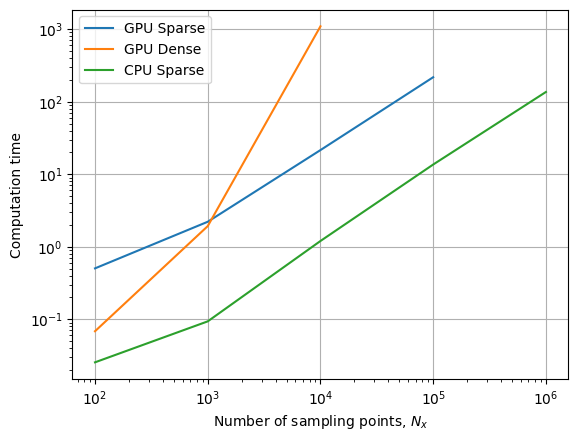

In [4]:
time_gpu_sparse = [0.5025563629997123, 2.207509797000057, 21.499866512000153, 217.3448648170006]
time_gpu = [0.06827249900015886, 1.9226194129996657, 1094.386678797]
time_cpu = [0.025435960000322666,
 0.09338311000101385,
 1.1988361000003351,
 13.589738923998084,
 136.06940258000031]
N_x = [10 ** i for i in range(2, 6)]

plt.plot(N_x, time_gpu_sparse, label='GPU Sparse')
plt.plot([100, 1000, 10000], time_gpu, label='GPU Dense')
plt.plot([100, 1000, 10000, 10 ** 5, 10 ** 6], time_cpu, label='CPU Sparse')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Computation time')
plt.xlabel(r'Number of sampling points, $N_x$')
plt.legend()
plt.grid()

In [33]:
def construct_hamiltonian(N_x, dx, V=None):
  Laplace = scipy.sparse.diags([1, -2, 1], offsets=[-1, 0, 1], shape=(N_x, N_x))
  H = -Laplace / (2 * dx ** 2)
  if V != None:
    H += scipy.sparse.spdiags(V, 0, N_x, N_x)
  return H.tocsr()


def time_evolution_operator(Hamiltonian, dt):
  U = scipy.linalg.expm(-1j * Hamiltonian * dt).toarray()
  U[(U.real**2 + U.imag**2) < 1e-14] = 0
  return scipy.sparse.csr_matrix(U)


##GIFs!!!

In [71]:
L = 130
N_x = 10000
N_t = 1000
x = np.linspace(-L+100, L, N_x)
t = np.linspace(0, 80, N_t)
dt = t[1] - t[0]
dx = x[1] - x[0]

p_0 = 1
x_0 = 0
sigma_x = 5
psi_0 = np.exp(-(x-x_0)**2 / (4 * sigma_x ** 2)) * np.exp(+1j*p_0*x)
norm = np.sqrt(np.sum(np.absolute(psi_0) ** 2) * dx)
psi_0 = psi_0 / norm

psi = np.zeros((N_x, N_t), dtype=np.complex64)
psi[:, 0] = psi_0


V = np.zeros((len(x), ))

gamma = (1j / 4) * (dt / dx ** 2)
RHS = scipy.sparse.diags([[gamma]*(N_x-1), 1-2*gamma-1j*dt*V/2, [gamma]*(N_x-1)], offsets=[-1, 0, 1], shape=(N_x, N_x)).tocsr()
LHS = scipy.sparse.diags([[-gamma]*(N_x-1), 1+2*gamma+1j*dt*V/2, [-gamma]*(N_x-1)], offsets=[-1, 0, 1], shape=(N_x, N_x)).tocsr()
for m in tqdm(range(1, N_t)):
  psi[:, m] = scipy.sparse.linalg.spsolve(LHS, RHS.dot(psi[:, m - 1]))
  psi[0, m] = psi[1, m]
  psi[-1, m] = psi[-2, m]
  norm = np.sum(np.absolute(psi[:, m]) ** 2) * dx
  psi[:, m] = psi[:, m] / np.sqrt(norm)

100%|██████████| 999/999 [00:12<00:00, 77.23it/s] 


In [78]:
def saving_picture(psi, i):
  plt.figure(figsize=(4.5, 4.5), dpi=150)
  plt.plot(x, np.abs(psi[:,i]), label = r'$|\psi|$')
  plt.plot(x, psi[:,i].imag, label = r'$Im(\psi)$')
  plt.plot(x, psi[:,i].real, label = r'$Re(\psi)$')
  plt.xlabel('x')
  plt.legend()
  plt.tight_layout()
  plt.savefig(f"/content/drive/My Drive/project/packet/{i}.png")
  plt.close()

for i in tqdm(range(N_t - 1)):
  saving_picture(psi, i)

100%|██████████| 999/999 [07:03<00:00,  2.36it/s]


In [85]:
filenames = [f"/content/drive/My Drive/project/packet/{i}.png" for i in range(0, N_t - 1, 10)]
images = []
for filename in tqdm(filenames):
    images.append(iio.imread(filename))
iio.imwrite("/content/drive/My Drive/project/packet/free.gif", images, format= 'gif', fps=23)

100%|██████████| 100/100 [00:01<00:00, 61.57it/s]


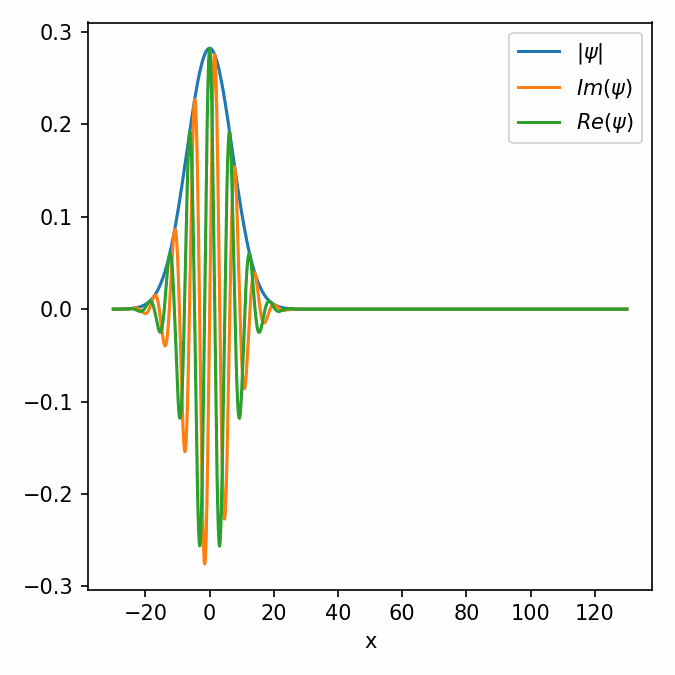

In [86]:
from IPython.display import Image
Image(open('/content/drive/My Drive/project/packet/free.gif','rb').read())

In [192]:
L = 320
N_x = 2000
N_t = 1000
x = np.linspace(-L, L, N_x)
t = np.linspace(0, 200, N_t)
dt = t[1] - t[0]
dx = x[1] - x[0]

p_0 = 1
x_0 = -48
sigma_x = 3
psi_0 = np.exp(-(x-x_0)**2 / (4 * sigma_x ** 2)) * np.exp(+1j*p_0*x)
norm = np.sqrt(np.sum(np.absolute(psi_0) ** 2) * dx)
psi_0 = psi_0 / norm

psi = np.zeros((N_x, N_t), dtype=np.complex64)
psi[:, 0] = psi_0


V = np.where((0 <= x) & (x < 1), 4, 0.0)


gamma = (1j / 4) * (dt / dx ** 2)
RHS = scipy.sparse.diags([[gamma]*(N_x-1), 1-2*gamma-1j*dt*V/2, [gamma]*(N_x-1)], offsets=[-1, 0, 1], shape=(N_x, N_x)).tocsr()
LHS = scipy.sparse.diags([[-gamma]*(N_x-1), 1+2*gamma+1j*dt*V/2, [-gamma]*(N_x-1)], offsets=[-1, 0, 1], shape=(N_x, N_x)).tocsr()
for m in tqdm(range(1, N_t)):
  psi[:, m] = scipy.sparse.linalg.spsolve(LHS, RHS.dot(psi[:, m - 1]))
  psi[0, m] = psi[1, m]
  psi[-1, m] = psi[-2, m]
  norm = np.sum(np.absolute(psi[:, m]) ** 2) * dx
  psi[:, m] = psi[:, m] / np.sqrt(norm)

100%|██████████| 999/999 [00:01<00:00, 561.39it/s]


In [221]:
def saving_picture(psi, i):
  plt.figure(figsize=(10, 5), dpi=150)
  plt.plot(x, np.abs(psi[:,i]), label = r'$|\psi|$')
  plt.axvline(x=0, color='r', label='Barrier')
  plt.axvline(x=1, color='r')
  plt.xlabel('x')
  plt.legend()
  plt.tight_layout()
  plt.savefig(f"/content/drive/My Drive/project/tunnel/{i}.png")
  plt.close()

for i in tqdm(range(0, N_t - 1, 10)):
  saving_picture(psi, i)

100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


In [222]:
filenames = [f"/content/drive/My Drive/project/tunnel/{i}.png" for i in range(0, N_t - 1, 10)]
images = []
for filename in tqdm(filenames):
    images.append(iio.imread(filename))
iio.imwrite("/content/drive/My Drive/project/tunnel/tunnel.gif", images, format= 'gif', fps=23)

100%|██████████| 100/100 [00:02<00:00, 36.05it/s]


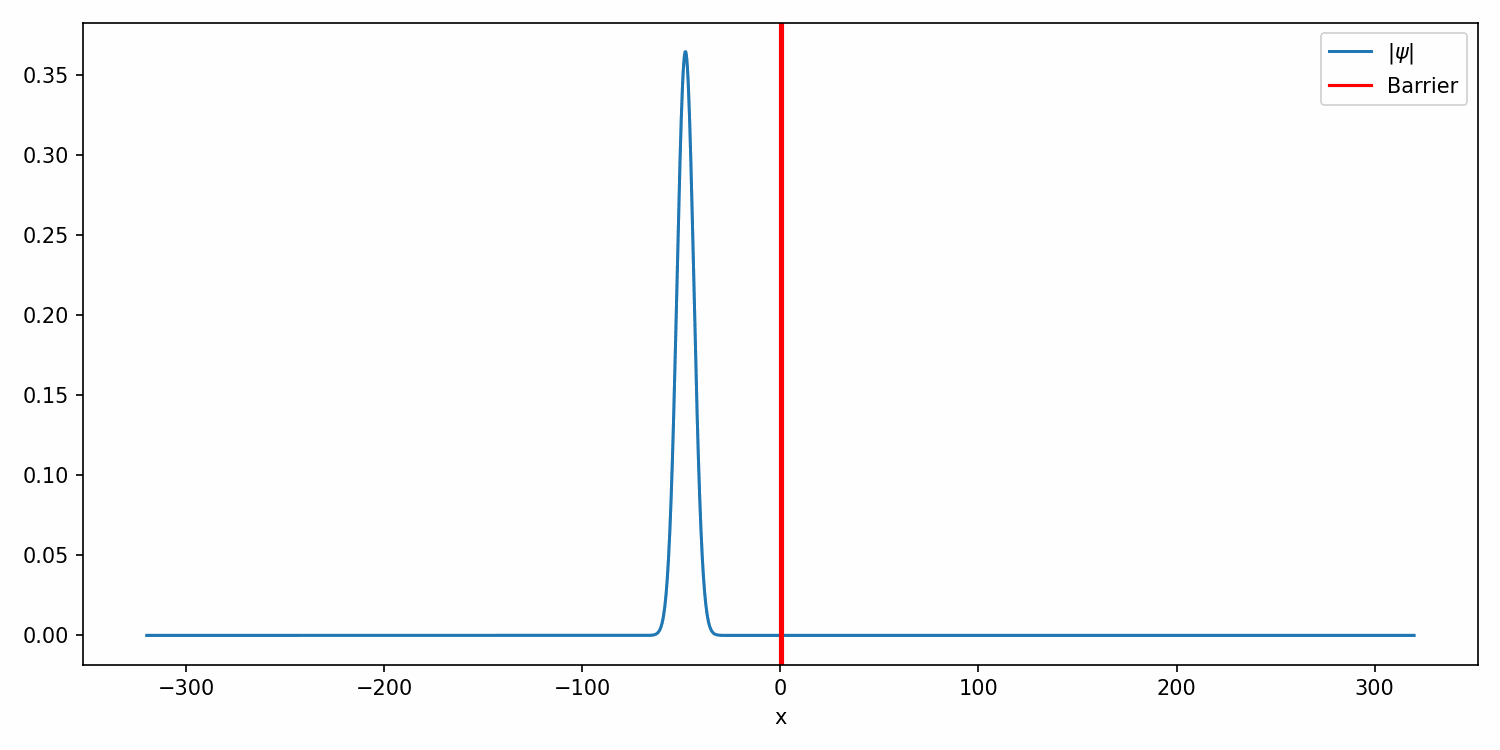

In [225]:
from IPython.display import Image
Image(open('/content/drive/My Drive/project/tunnel/tunnel.gif','rb').read())

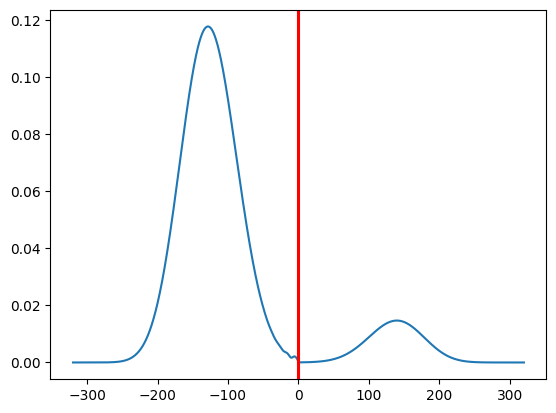

In [216]:
plt.plot(x, np.abs(psi[:,900]), label = r'$|\psi|$')
plt.axvline(x=0, color='r')
plt.axvline(x=1, color='r')